The third part is dedicated to the data visualition and analysis. With figures and some statistical tests, we aim to answer the following questions:
- Have wildfires become more or less frequent over time?
- What are the seasonal dynamics of wildfires?
- What states are the most and least fire-prone?

First, import and clean data.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Connect to the database and import the table 'Fires'
import os
import sqlite3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


conn = sqlite3.connect('/kaggle/input/us-wildfire-records-6th-edition/data.sqlite') 
df = pd.read_sql_query('SELECT * FROM Fires;', con=conn)

# Close connection
conn.close()

# Select only columns of interest
col_of_interest = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE' , 'LONGITUDE' , 'STATE']
df = df[col_of_interest].set_index('OBJECTID', verify_integrity = True)

# Rename the columns and the index
df = df.rename(columns = {'FIRE_YEAR':'fire_year',
                         'DISCOVERY_DATE':'disc_date',
                         'DISCOVERY_DOY':'disc_doy',
                         'NWCG_GENERAL_CAUSE':'cause',
                         'CONT_DATE':'cont_date',
                         'CONT_TIME':'cont_time',
                         'FIRE_SIZE' : 'fire_size',
                         'FIRE_SIZE_CLASS' : 'fire_class',
                         'LATITUDE':'latitude',
                         'LONGITUDE':'longitude',
                         'STATE':'state'}).rename_axis('id')

# Convert the columns 'disc_date' and 'cont_date' in datetime format and add a colmun with the month
df['disc_date'] = pd.to_datetime(pd.to_datetime(df['disc_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df['cont_date'] = pd.to_datetime(pd.to_datetime(df['cont_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df.insert(3, 'disc_month', df['disc_date'].dt.month)
df.insert(4, 'disc_day', df['disc_date'].dt.day_name())

# Define a new column 'origin'
map_cause = {'Power generation/transmission/distribution':'Accidental',
            'Natural':'Natural',
            'Debris and open burning':'Accidental',
            'Missing data/not specified/undetermined':'Undefined',
            'Recreation and ceremony':'Accidental',
            'Equipment and vehicle use':'Accidental',
            'Arson/incendiarism':'Criminal',
            'Fireworks':'Accidental',
            'Other causes':'Accidental',
            'Railroad operations and maintenance':'Accidental',
            'Smoking':'Accidental',
            'Misuse of fire by a minor':'Accidental',
            'Firearms and explosives use':'Accidental'}

df['origin'] = df['cause'].map(map_cause)

# Limit the analysis to contiguous US
# df = df.loc[(df['latitude']>=25) & (df['latitude']<=50)]
df['geo_area'] = np.char.add(np.where(df['latitude'] >= 38.0, 'N', 'S'), np.where(df['longitude'] >= -100, 'E', 'W'))

df.head()

/kaggle/input/us-wildfire-records-6th-edition/_variable_descriptions.csv
/kaggle/input/us-wildfire-records-6th-edition/data.sqlite
/kaggle/input/us-wildfire-records-6th-edition/data.csv


,fire_year,disc_date,disc_doy,disc_month,disc_day,cause,cont_date,cont_time,fire_size,fire_class,latitude,longitude,state,origin,geo_area
id,,,,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,Power generation/transmission/distribution,2005-02-02,1730,0.10,A,40.036944,-121.005833,CA,Accidental,NW
2,2004,2004-05-12,133,5,Wednesday,Natural,2004-05-12,1530,0.25,A,38.933056,-120.404444,CA,Natural,NW
3,2004,2004-05-31,152,5,Monday,Debris and open burning,2004-05-31,2024,0.10,A,38.984167,-120.735556,CA,Accidental,NW
4,2004,2004-06-28,180,6,Monday,Natural,2004-07-03,1400,0.10,A,38.559167,-119.913333,CA,Natural,NW
5,2004,2004-06-28,180,6,Monday,Natural,2004-07-03,1200,0.10,A,38.559167,-119.933056,CA,Natural,NW


# **1. Long term trends: Have wildfires become more or less frequent over time?**

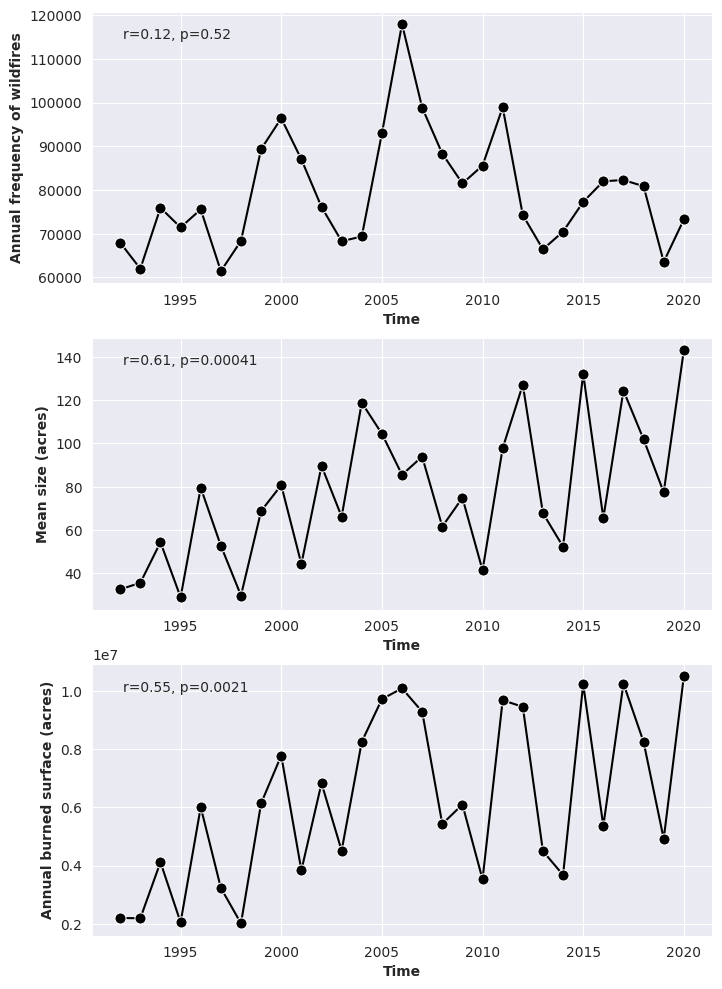

In [2]:
import scipy as sp

# Summurize several properties of wildfires by year
df_trends = pd.DataFrame(
    index = np.arange(1992, 2021, 1),
    columns = ['Nbr_fire', 'Average_size_fire' , 'Total_fire_size']
)

df_trends['Nbr_fire'] =  df['fire_year'].value_counts(sort = False)
df_trends['Average_size_fire'] = df.groupby('fire_year').agg({'fire_size':'mean'})
df_trends["Total_fire_size"] = df.groupby('fire_year').agg({'fire_size':'sum'})

# Figures properties
colonnes = ['Nbr_fire', 'Average_size_fire', 'Total_fire_size']
y_names = ['Annual frequency of wildfires', 'Mean size (acres)', 'Annual burned surface (acres)']
axes = [311, 312, 313]
liste_color = ['black', 'black', 'black']

fig = plt.figure(figsize = (8,12))

sns.set_style("darkgrid")

# Make figures and statistical tests to quantify long-term trends of wildfires
for col, name, j, coul in zip(colonnes, y_names, axes, liste_color):
    ax = plt.subplot(j)
    sns.lineplot(x = df_trends.index.values, y = col, data = df_trends, markers = True, marker = 'o', color = coul, markersize = 8)
    r, p = sp.stats.pearsonr(df_trends.index.values, df_trends[col])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes, size = 10)
    plt.ylabel(name, fontweight ='bold', size = 10)
    plt.xlabel('Time', fontweight = 'bold', size = 10)

plt.show()

Overall, there is no significant increase in the annual fequency of wildfire over the study period. However, we do observe a significant increase in their mean size, and, subsequently, in the annual area of burned surface.

Now let's see more in details these trends by doing the same figures as above but for each origin of wildfires.

In [3]:
import plotly.express as px
import plotly.subplots as psp
import plotly.graph_objects as go

# Summurize several properties of wildfires by year and by origin
frequency_by_origine = df.groupby('fire_year')['origin'].value_counts().unstack()
frequency_by_origine.columns = frequency_by_origine.columns.str.capitalize()

mean_size_by_origine = round(df.groupby(['fire_year', 'origin']).agg({'fire_size':'mean'}),1).unstack()
mean_size_by_origine.columns = ['Accidental', 'Criminal', 'Natural', 'Undefined']

burned_surf_by_origine = round(df.groupby(['fire_year', 'origin']).agg({'fire_size':'sum'}),0).unstack()
burned_surf_by_origine.columns = ['Accidental', 'Criminal', 'Natural', 'Undefined']

liste1 = ['Accidental', 'Criminal', 'Natural', 'Undefined']
liste2 = ['%Accidental', '%Criminal', '%Natural', '%Undefined']

for origine, col in zip(liste1, liste2):
    burned_surf_by_origine[col] = round(burned_surf_by_origine[origine]/burned_surf_by_origine.sum(axis = 1)*100,1)

# Make the figures
figure1 = px.line(frequency_by_origine, x=frequency_by_origine.index, 
              y=['Accidental', 'Criminal', 'Natural', 'Undefined'], 
              markers = True,
              labels = {'fire_year':'Time', 
                       'value':'Nbr of wildfire per year', 
                       'variable':'Origine'}, 
             color_discrete_sequence=["deepskyblue", "red", "limegreen", "grey"])

figure1.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='white'))
                 )

figure2 = px.line(mean_size_by_origine, x=mean_size_by_origine.index, 
              y=['Accidental', 'Criminal', 'Natural', 'Undefined'], 
              markers = True,
             color_discrete_sequence=["deepskyblue", "red", "limegreen", "grey"])

figure2.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='white'))
                 )


figure3 = px.line(burned_surf_by_origine, x=mean_size_by_origine.index, 
              y=['Accidental', 'Criminal', 'Natural', 'Undefined'], 
              markers = True,
             color_discrete_sequence=["deepskyblue", "red", "limegreen", "grey"]
                 )

figure3.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='white'))
                 )


figure4 = px.line(burned_surf_by_origine, x=mean_size_by_origine.index, 
              y=['%Accidental', '%Criminal', '%Natural', '%Undefined'], 
              markers = True,
             color_discrete_sequence=["deepskyblue", "red", "limegreen", "grey"]
                 )

figure4.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='white'))
                 )

# Gather the figures in one subplot
figure1_traces = []
figure2_traces = []
figure3_traces = []
figure4_traces = []

for trace in range(len(figure1["data"])):
    figure1_traces.append(figure1["data"][trace])
for trace in range(len(figure2["data"])):
    figure2["data"][trace]['showlegend'] = False             
    figure2_traces.append(figure2["data"][trace])
for trace in range(len(figure3["data"])):
    figure3["data"][trace]['showlegend'] = False             
    figure3_traces.append(figure3["data"][trace])
for trace in range(len(figure4["data"])):
    figure4["data"][trace]['showlegend'] = False             
    figure4_traces.append(figure4["data"][trace])
    
# Create a 1x3 subplot
this_figure = psp.make_subplots(rows = 1, cols = 4)#, subplot_titles = ['Annual frequency', 'Mean size (acres)'])
this_figure.update_layout(height = 500, width = 1600, title_text = "Long term trends of wildfires by origin", title_font_size = 25)

# Get the Express fig broken down as traces and add the traces to the proper plot within the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row = 1, col = 1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row = 1, col = 2)
for traces in figure3_traces:
    this_figure.append_trace(traces, row = 1, col = 3)
for traces in figure4_traces:
    this_figure.append_trace(traces, row = 1, col = 4)

# Update the different elements
ylabels = ['Annual frequency','Mean size (acres)','Annual burned surface (acres)', 'Relative contribution to burned area (%)']
cols = [1, 2, 3, 4]

for labels, col in zip (ylabels, cols):
    this_figure.update_yaxes(title_text = labels, row = 1, col = col)
    this_figure.update_xaxes(title_text = 'Time', row = 1, col = col)

this_figure.show()

# Upload to GitHub repository
# this_figure.show('png')

In [5]:
# Define a function to analyse the statistical relationships between time and wildfires properties depending on their origin
def get_stats(df):
    pearsonr = []
    p_value = []

    for col in df.columns:
        r, p = sp.stats.pearsonr(df.index, df[col])
        pearsonr.append(r)
        p_value.append(p)

    table = pd.DataFrame(columns = df.columns,
                        index = ['Pearson_r','p_value'])
    table.iloc[0,:] = pearsonr
    table.iloc[1,:] = p_value

    print(table)

# Apply these tests
print('Statistics for long term trends in the annual frequency of wildfire by origin')
get_stats(frequency_by_origine)
print("\n")
print('Statistics for long term trends in the mean size of wildfire by origin')
get_stats(mean_size_by_origine)
print("\n")
print('Statistics for long term trends in the annual burned surface by wildfire by origin')
get_stats(burned_surf_by_origine)

Statistics for long term trends in the annual frequency of wildfire by origin
origin    Accidental  Criminal   Natural Undefined
Pearson_r   0.091866 -0.600087 -0.468855  0.678438
p_value     0.635532  0.000579  0.010301  0.000052


Statistics for long term trends in the mean size of wildfire by origin
          Accidental  Criminal   Natural Undefined
Pearson_r   0.470649  0.090146  0.612498  0.503418
p_value     0.009975  0.641898  0.000413  0.005371


Statistics for long term trends in the annual burned surface by wildfire by origin
          Accidental  Criminal   Natural Undefined %Accidental %Criminal  \
Pearson_r   0.422725 -0.332527  0.374232  0.617308   -0.193348 -0.748677   
p_value     0.022336  0.077987    0.0455  0.000361     0.31493  0.000003   

           %Natural %Undefined  
Pearson_r  0.017795   0.423086  
p_value       0.927    0.02221  


In [6]:
# Analyse relationship between origin and fire_size, using the class of wildfire
ct = pd.crosstab(df['fire_class'], df['origin'])
display(ct)

from scipy.stats import chi2_contingency
resultats_chi2 = chi2_contingency(ct)

statistique = resultats_chi2[0]
p_valeur = resultats_chi2[1]
print("p value = ", p_valeur, "\n")

origin,Accidental,Criminal,Natural,Undefined
fire_class,,,,
A,363277,76371,177740,259021
B,565722,170758,100901,267006
C,109066,62799,29099,56132
D,11534,7167,7077,8230
E,4935,2682,5241,4333
F,2183,851,4307,2351
G,783,186,2954,860


p value =  0.0 



- Accidental is the most frequent origin for wildfire and shows no significant long term pattern. Accidental and Natural origins seem to decrease since the mid 2000, however these patterns are mirrored by an increase in the Undefined origin, so caution is required here.
- The mean size and burned surface of fire show significant increases for all origin except for those of criminal origin. These increases are particularly strong for natural wildfires that are responsible for most of the megafires (classes F and G).

# **2. What are the seasonal dynamics of wildfires? Are the patterns similar across the whole US?**

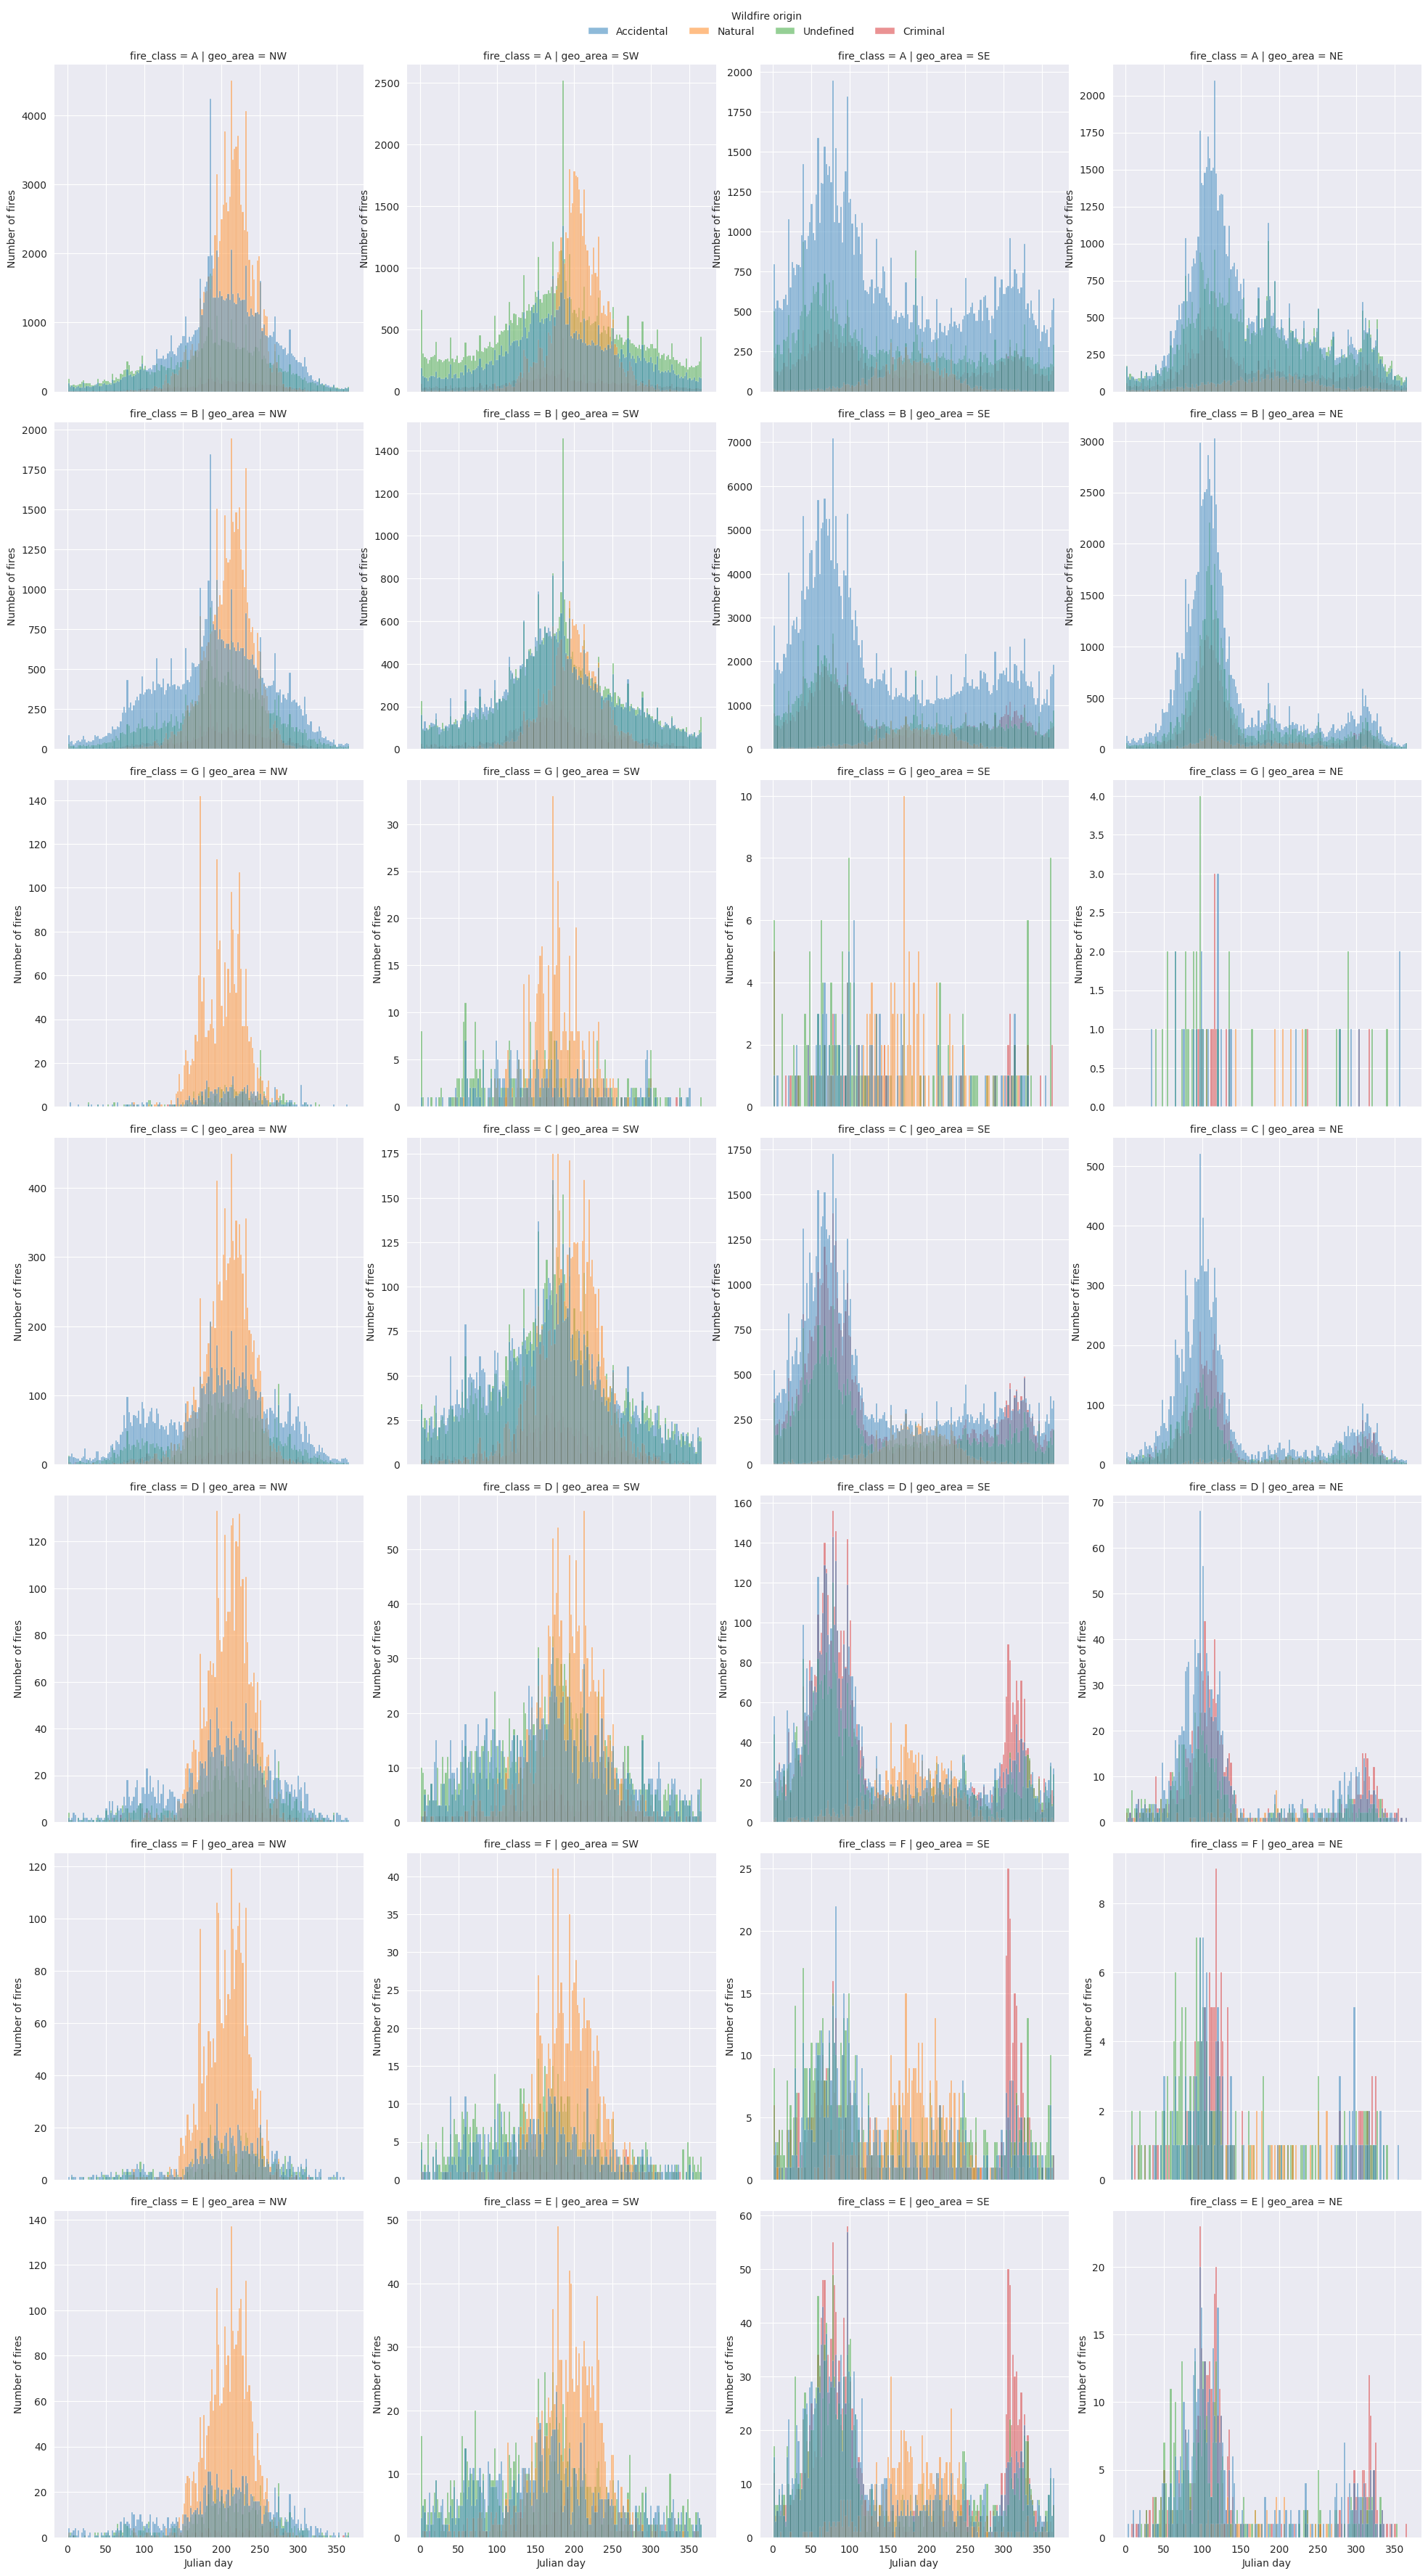

In [7]:
ax = sns.displot(df, 
                 x = df.disc_doy,
                 hue = 'origin',
                 col = 'geo_area',
                 row = 'fire_class',
                 facet_kws=dict(sharey=False));

ax.set(xlabel='Julian day', 
       ylabel='Number of fires')

sns.move_legend(ax, "upper center",
               bbox_to_anchor=(0.5, 1.015), ncol=4, title='Wildfire origin', frameon=False)

- Seasonality varies greatly across regions of the US along a West-East gradient, with unimodal (peak in June - August) and bimodal (main peak in March-May and second peak in September-October) distributions in the West and East, respectively.
- Origin of wildifres alos varies greatly between the West (main cause = natural) and the East (main cause = accidental/criminal)
- Overall, seasonality for the different size class is similar, depending on the region.

# **3. What is the daily variability of wildfires?**

In [9]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_criminal = df[df['origin'] == 'Criminal']
df_natural = df[df['origin'] == 'Natural']
df_accident = df[df['origin'] == 'Accidental']

week_crimes = df_criminal.groupby([df_criminal['disc_day']])['disc_day'].value_counts().reindex(cats)
week_natural = df_natural.groupby([df_natural['disc_day']])['disc_day'].value_counts().reindex(cats)
week_accident = df_accident.groupby([df_accident['disc_day']])['disc_day'].value_counts().reindex(cats)

figure1 = px.bar(week_crimes, x='count',
             width = 600,
             height = 400,
             labels = {'disc_day':'',
                       'count' : 'Count'},
             title = 'Repartition of criminal wildfires during the week')

figure2 = px.bar(week_natural, x='count',
             width = 600,
             height = 400,
             labels = {'disc_day':'',
                       'count' : 'Count'},
             title = 'Repartition of natural wildfires during the week')

figure3 = px.bar(week_accident, x='count',
             width = 600,
             height = 400,
             labels = {'disc_day':'',
                       'count' : 'Count'},
             title = 'Repartition of accidental wildfires during the week')

# Gather the figures in one subplot
figure1_traces = []
figure2_traces = []
figure3_traces = []

for trace in range(len(figure1["data"])):
    figure1_traces.append(figure1["data"][trace])
for trace in range(len(figure2["data"])):
    figure2["data"][trace]['showlegend'] = False             
    figure2_traces.append(figure2["data"][trace])
for trace in range(len(figure3["data"])):
    figure3["data"][trace]['showlegend'] = False             
    figure3_traces.append(figure3["data"][trace])

    
# Create a 1x3 subplot
this_figure = psp.make_subplots(rows = 1, cols = 3, subplot_titles = ['Criminal','Natural', 'Accidental'])
this_figure.update_layout(height = 500, width = 1600, title_text = "Repartition of wildfires during the week by origin", title_font_size = 25)

# Get the Express fig broken down as traces and add the traces to the proper plot within the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row = 1, col = 1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row = 1, col = 2)
for traces in figure3_traces:
    this_figure.append_trace(traces, row = 1, col = 3)

# Update the different elements
this_figure.update_xaxes(title_text = 'Count')

this_figure.show()


As we could expected, natural wildfires do not present any significant pattern during the week. However, criminal and accidental wildfires trend to increase during the week-end, with a net peak for accidental wildfire on Saturday. 

# **4. What states are the most and least fire-prone? What are the dominant causes and how they vary spatially?**

In [7]:
top5_states = df.state.value_counts()[:5].sort_values()
least5_states = df.state.value_counts()[-5:].sort_values()


fig_top5 =px.bar(top5_states,
             x = top5_states.values)

fig_least5 =px.bar(least5_states,
             x = least5_states.values)

figure1_traces = []
figure2_traces = []

for trace in range(len(fig_top5["data"])):
    figure1_traces.append(fig_top5["data"][trace])
for trace in range(len(fig_least5["data"])):
    fig_least5["data"][trace]['showlegend'] = False             
    figure2_traces.append(fig_least5["data"][trace])

this_figure = psp.make_subplots(rows = 2, cols = 1, subplot_titles = ['TOP 5', 'LEAST 5'])
this_figure.update_layout(height = 600, width = 800, title_text = "TOP and LEAST states", title_font_size = 25)

for traces in figure1_traces:
    this_figure.append_trace(traces, row = 1, col = 1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row = 2, col = 1)

rows = [1, 2]

for row in rows:
    this_figure.update_yaxes(title_text = 'States', row = row, col = 1)
    this_figure.update_xaxes(title_text = 'Number of wildfires between 1992 and 2020', row = row, col = 1)

this_figure.show()

In [8]:
top5_causes = df[df['cause'] != 'Missing data/not specified/undetermined'].cause.value_counts()[:5].sort_values()
top5_causes_CA = df[(df['cause'] != 'Missing data/not specified/undetermined') & (df['state'] == 'CA')].cause.value_counts()[:5].sort_values()
top5_causes_GA = df[(df['cause'] != 'Missing data/not specified/undetermined') & (df['state'] == 'GA')].cause.value_counts()[:5].sort_values()

fig_all_us =px.bar(top5_causes,
             x = top5_causes.values)

fig_CA =px.bar(top5_causes_CA,
             x = top5_causes_CA.values)


fig_GA =px.bar(top5_causes_GA,
             x = top5_causes_GA.values)

figure1_traces = []
figure2_traces = []
figure3_traces = []

for trace in range(len(fig_all_us["data"])):
    figure1_traces.append(fig_all_us["data"][trace])
for trace in range(len(fig_CA["data"])):
    fig_CA["data"][trace]['showlegend'] = False             
    figure2_traces.append(fig_CA["data"][trace])
for trace in range(len(fig_GA["data"])):
    fig_GA["data"][trace]['showlegend'] = False             
    figure3_traces.append(fig_GA["data"][trace])

this_figure = psp.make_subplots(rows = 3, cols = 1, subplot_titles = ['All US', 'California (TOP 1)', 'Georgia (TOP 2)'])
this_figure.update_layout(height = 800, width = 800, title_text = "TOP 5 causes", title_font_size = 25)

for traces in figure1_traces:
    this_figure.append_trace(traces, row = 1, col = 1)
for traces in figure2_traces:
    this_figure.append_trace(traces, row = 2, col = 1)
for traces in figure3_traces:
    this_figure.append_trace(traces, row = 3, col = 1)

rows = [1, 2, 3]

for row in rows:
    this_figure.update_yaxes(title_text = 'Cause', row = row, col = 1)
    this_figure.update_xaxes(title_text = 'Number of wildfires between 1992 and 2020', row = row, col = 1)

this_figure.show()

In [9]:
nbr_wilfires_by_causes = df.groupby(['cause', 'origin'])['disc_doy'].count().reset_index('origin').sort_values(by = 'disc_doy')

fig_nbr_wilfires_by_causes =px.bar(nbr_wilfires_by_causes,
                                   x = nbr_wilfires_by_causes.disc_doy,
                                   color = nbr_wilfires_by_causes.origin,
                       color_discrete_sequence = ["deepskyblue", "red", "limegreen", "grey"],
                       width = 1200,
                       height = 600,
                       title = 'Number of wildfires by Cause from 1992 to 2020',
                       labels = {'disc_doy' : 'Number of wilfires',
                                'cause' : 'Cause',
                                'origin' : 'Origin'},
                       category_orders={'cause': nbr_wilfires_by_causes.index[::-1]}
                      )


fig_nbr_wilfires_by_causes.show()

In [10]:
mean_size_by_causes = df.groupby(['cause', 'origin'])['fire_size'].mean().reset_index('origin').sort_values(by = 'fire_size')

fig_mean_size_cause =px.bar(mean_size_by_causes,
                       x = mean_size_by_causes.fire_size,
                       color = mean_size_by_causes.origin,
                       color_discrete_sequence = ["deepskyblue", "red", "grey", "limegreen"],
                       width = 1200,
                       height = 600,
                       title = 'Mean wildfire size by cause from 1992 to 2020',
                       labels = {'fire_size' : 'Mean wildfire size (acres)',
                                'cause' : 'Cause',
                                'origin' : 'Origin'},
                       category_orders={'cause': mean_size_by_causes.index[::-1]}
                      )

fig_mean_size_cause.show()

In [11]:
burned_area_by_causes = df.groupby(['cause', 'origin'])['fire_size'].sum().reset_index('origin').sort_values(by = 'fire_size')

fig_burned_area_by_causes =px.bar(burned_area_by_causes,
                       x = burned_area_by_causes.fire_size,
                       color = burned_area_by_causes.origin,
                       color_discrete_sequence = ["deepskyblue", "red", "grey", "limegreen"],
                       width = 1200,
                       height = 600,
                       title = 'Burned area by cause from 1992 to 2020',
                       labels = {'fire_size' : 'Mean wildfire size (acres)',
                                'cause' : 'Cause',
                                'origin' : 'Origin'},
                       category_orders={'cause': burned_area_by_causes.index[::-1]}
                      )

fig_burned_area_by_causes.show()

- Causes vary largely spatially, however human are the dominant reason for wildfires.
- Although not dominant in frequency, natural wildfire are the most dramatic in terms of dammages.

In [12]:
df['duration'] = df['cont_date'] - df['disc_date']
mean_duration_by_cause = df.groupby(['cause', 'origin'])['duration'].mean().reset_index('origin').sort_values(by = 'duration')

fig_mean_duration =px.bar(mean_duration_by_cause,
                       x = mean_duration_by_cause.duration.dt.total_seconds().div(86400),
                       color = mean_duration_by_cause.origin,
                       color_discrete_sequence = ["deepskyblue", "red", "grey", "limegreen"],
                       width = 1200,
                       height = 600,
                       title = 'Mean duration of wildfires by cause from 1992 to 2020',
                       labels = {'x' : 'Mean duration (days)',
                                'cause' : 'Cause',
                                'origin' : 'Origin'},
                       category_orders={'cause': mean_duration_by_cause.index[::-1]}
                      )

fig_mean_duration.show()

Longuer wildfires are from natural origin.